In [80]:
# from google.colab import files
# uploaded = files.upload()

In [81]:
#importing used libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler


In [82]:
#Reading the dataframe

df = pd.read_csv("Student Performance Prediction-Binary.csv")
df = df.drop(["Total [100]","Student ID"], axis = 1)
df.head()


,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Class
0,95,91,70,90,84,64,85,G
1,85,76,65,61,73,64,76,G
2,85,41,73,61,73,61,73,G
3,80,78,80,79,79,57,80,G
4,85,91,78,80,84,67,85,G


In [83]:
# Assigning the features and target variables

X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
Y

0      G
1      G
2      G
3      G
4      G
      ..
481    G
482    G
483    G
484    G
485    G
Name: Class, Length: 486, dtype: object

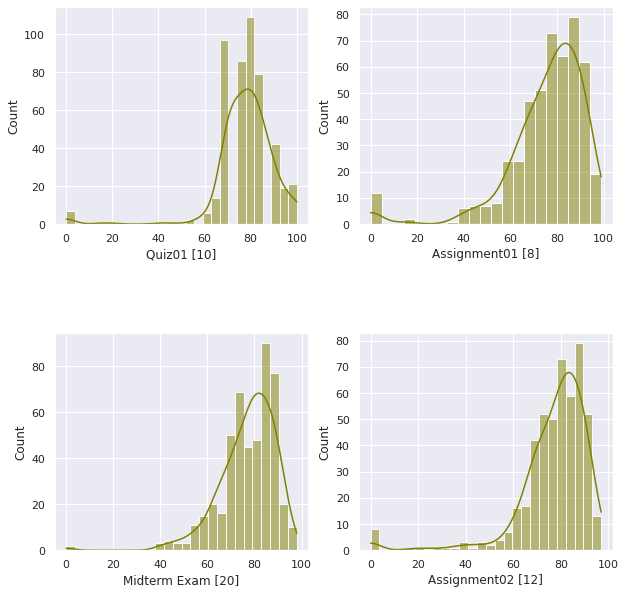

In [84]:
# plotting histograms for each feature

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.set(style="darkgrid")

features = df.columns[:4]
features = np.array(features).reshape((2,2))

for i in range(features.shape[0]):

    for j in range(features.shape[1]):

     sns.histplot(data=df[features[i][j]], kde=True, color="olive", ax=axs[i, j])
plt.subplots_adjust(hspace=0.5)
plt.show()

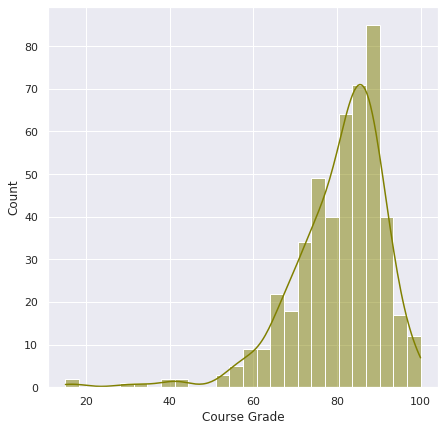



Mean = 80.38271604938272 and std = 11.267031992829931


In [85]:
#ploting final grade distribution

plt.figure(figsize = (7,7))

sns.set(style="darkgrid")
sns.histplot(df["Course Grade"],label = "Course Grade distribution", kde=True, color="olive");

plt.show()
print('\n')
print("Mean = {} and std = {}".format(df["Course Grade"].mean(),df["Course Grade"].std()))


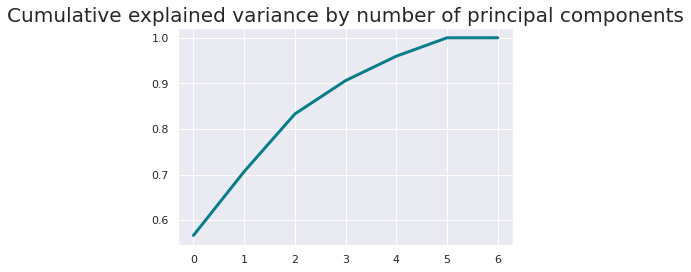

In [86]:
# Performing PCA for visualizing data and determing important features
X_scaled = X

scalar = StandardScaler()
scalar.fit(X_scaled)
X_scaled = scalar.transform(X_scaled) # Normalizing the data before PCA

pca = PCA().fit(X_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()


In [87]:
# PCA loadings to decide importance of features
X_scaled_df = pd.DataFrame(X_scaled,columns = df.columns[:-1])

loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_scaled_df.columns) + 1)],
    index= X_scaled_df.columns
)
loadings.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Quiz01 [10],-0.410669,-0.277148,-0.863314,0.061943,0.084214,-0.018850,0.002564
Assignment01 [8],-0.749697,-0.363951,0.059895,-0.418701,-0.318127,0.165670,0.002612
Midterm Exam [20],-0.660087,0.567767,-0.060772,-0.409004,0.259888,-0.073816,0.004446
Assignment02 [12],-0.805736,-0.337945,0.236310,0.073011,0.001318,-0.421259,0.003365
Assignment03 [25],-0.793914,-0.273409,0.273636,0.203090,0.334676,0.262382,0.005936


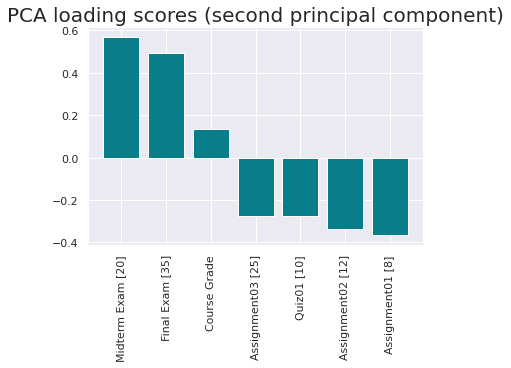

In [88]:
#loaidng scores for PC2 as example

pc1_loadings = loadings.sort_values(by='PC2', ascending=False)[['PC2']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (second principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [89]:
    #visualizing the data with the first 2 PCs (about 71% variance)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['Class']]], axis = 1)
finalDf

,principal component 1,principal component 2,Class
0,-1.078204,-1.250460,G
1,1.035658,-0.197673,G
2,1.764481,0.773825,G
3,-0.010902,-0.136609,G
4,-0.957244,-0.338349,G
...,...,...,...
481,-1.972592,0.726316,G
482,-1.131471,1.798774,G
483,-2.658712,0.787720,G
484,0.343567,-0.208847,G


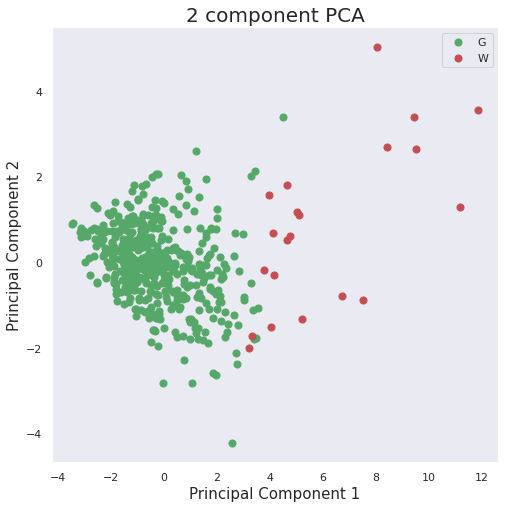

In [90]:
#visualizing data

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['G', 'W']
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Machine Learning Model : K-NN

In [91]:
for i in range(len(Y)):

    if Y[i] == 'G':

        Y[i] = 1

    else:

        Y[i] = 0

Y = Y.astype('int')




<ipython-input-91-c5e17d15c43c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[i] = 1
<ipython-input-91-c5e17d15c43c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[i] = 0


In [92]:
#building the model with 50% of data

X_20  = X.iloc[:,:2]
X_20

,Quiz01 [10],Assignment01 [8]
0,95,91
1,85,76
2,85,41
3,80,78
4,85,91
...,...,...
481,90,85
482,80,68
483,80,86
484,75,68


In [93]:
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X_20, Y, test_size=0.2,random_state=100)


In [94]:
# defining k-nn model with precision evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid = GridSearchCV(classifier, params, cv=3, scoring= "precision", return_train_score=True,verbose=1)

grid_search1 = grid.fit(x_train,y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [95]:
#print(grid_search.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

0.9866366917607786
{'n_neighbors': 4}


In [96]:
y_pred = grid.predict(x_test)
y_proba = grid.predict_proba(x_test)
precision_score(y_test,y_pred)

0.9375

In [97]:
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_proba[:,1]))

0.989010989010989
0.9625668449197862
0.6318681318681318


In [98]:
# defining k-nn model with recall evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid1 = GridSearchCV(classifier, params, cv=3, scoring= "recall", return_train_score=True,verbose=1)

grid_search1 = grid1.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [99]:
print(grid1.best_score_)
print(grid1.best_params_)

1.0
{'n_neighbors': 13}


In [100]:
y_pred = grid1.predict(x_test)
y_proba = grid1.predict_proba(x_test)
recall_score(y_test,y_pred)

0.989010989010989

In [101]:
print(precision_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_proba[:,1]))

0.9278350515463918
0.9574468085106383
0.8108320251177394


In [102]:
# defining k-nn model with F1 score evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid2 = GridSearchCV(classifier, params, cv=3, scoring= "f1", return_train_score=True,verbose=1)

grid_search2 = grid2.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [103]:
print(grid2.best_score_)
print(grid2.best_params_)

0.9841686455859685
{'n_neighbors': 7}


In [104]:
y_pred = grid2.predict(x_test)
y_proba = grid2.predict_proba(x_test)
f1_score(y_test,y_pred)

0.9574468085106383

In [105]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_proba[:,1]))

0.9278350515463918
0.989010989010989
0.6883830455259028


In [106]:
# defining k-nn model with roc-auc evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid3 = GridSearchCV(classifier, params, cv=3, scoring= "roc_auc", return_train_score=True,verbose=1)

grid_search3 = grid3.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [107]:
print(grid3.best_score_)
print(grid3.best_params_)

0.9377204301075269
{'n_neighbors': 12}


In [108]:
y_pred = grid3.predict(x_test)
y_proba = grid3.predict_proba(x_test)
roc_auc_score(y_test,y_proba[:,1])

0.8108320251177394

In [109]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.9278350515463918
0.989010989010989
0.9574468085106383


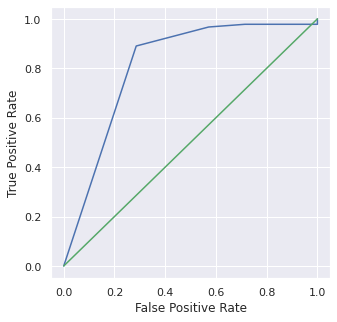

In [110]:
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_test, y_proba[:, 1])

In [111]:
#building the model with 50% of data

X_50  = X.iloc[:,:4]
X_50

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12]
0,95,91,70,90
1,85,76,65,61
2,85,41,73,61
3,80,78,80,79
4,85,91,78,80
...,...,...,...,...
481,90,85,93,87
482,80,68,93,70
483,80,86,93,95
484,75,68,80,76


In [112]:
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X_50, Y, test_size=0.2,random_state=100)


In [113]:
# defining k-nn model with precision evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid = GridSearchCV(classifier, params, cv=3, scoring= "precision", return_train_score=True,verbose=1)

grid_search1 = grid.fit(x_train,y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [114]:
#print(grid_search.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

0.9920839895013124
{'n_neighbors': 4}


In [115]:
y_pred = grid.predict(x_test)
y_proba = grid.predict_proba(x_test)
precision_score(y_test,y_pred)

0.9375

In [116]:
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_proba[:,1]))

0.989010989010989
0.9625668449197862
0.6263736263736264


In [117]:
# defining k-nn model with recall evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid1 = GridSearchCV(classifier, params, cv=3, scoring= "recall", return_train_score=True,verbose=1)

grid_search1 = grid1.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [118]:
print(grid1.best_score_)
print(grid1.best_params_)

1.0
{'n_neighbors': 5}


In [119]:
y_pred = grid1.predict(x_test)
y_proba = grid1.predict_proba(x_test)
recall_score(y_test,y_pred)

0.989010989010989

In [120]:
print(precision_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_proba[:,1]))

0.9375
0.9625668449197862
0.6263736263736264


In [121]:
# defining k-nn model with F1 score evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid2 = GridSearchCV(classifier, params, cv=3, scoring= "f1", return_train_score=True,verbose=1)

grid_search2 = grid2.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [122]:
print(grid2.best_score_)
print(grid2.best_params_)

0.9934019281845369
{'n_neighbors': 6}


In [123]:
y_pred = grid2.predict(x_test)
y_proba = grid2.predict_proba(x_test)
f1_score(y_test,y_pred)

0.9625668449197862

In [124]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(roc_auc_score(y_test,y_proba[:,1]))

0.9375
0.989010989010989
0.6970172684458399


In [125]:
# defining k-nn model with roc-auc evaluation

classifier = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(4,44)]}

grid3 = GridSearchCV(classifier, params, cv=3, scoring= "roc_auc", return_train_score=True,verbose=1)

grid_search3 = grid3.fit(x_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [126]:
print(grid3.best_score_)
print(grid3.best_params_)

0.9491247311827958
{'n_neighbors': 39}


In [127]:
y_pred = grid3.predict(x_test)
y_proba = grid3.predict_proba(x_test)
roc_auc_score(y_test,y_proba[:,1])

0.8783359497645213

In [128]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.9285714285714286
1.0
0.962962962962963


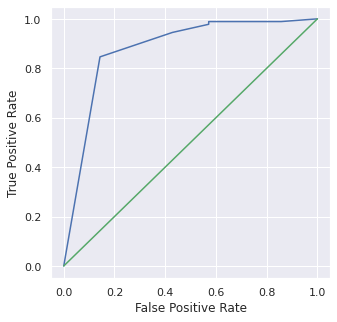

In [129]:
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_test, y_proba[:, 1])